# Embedded ML Lab - Challenge (training yolo example)

This is an example of training with the VOC data set and tinyyolov2. Since training tinyyolo from scratch takes a very long time we start with pretrained weights.

In [1]:
%cd ..

/home/chickencurry/emb-ml-challenge


In [2]:
import torch
from utils.tinyyolov2 import TinyYoloV2, TinyYoloV2Pruned
from utils.loss import YoloLoss
from utils.dataloader import VOCDataLoaderPerson
from utils.train_eval import train

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# import torch_directml
# device = torch_directml.device()
# print(device)

In [5]:
run = "runs/voc_pretrained.pt"

net = TinyYoloV2(num_classes=1)
sd = torch.load(run)

# We load all parameters from the pretrained dict except for the last layer
net.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)

# net.load_state_dict(sd)

# We only train the last layer (conv9)
for key, param in net.named_parameters():
    if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
        param.requires_grad = False
    elif any(x in key for x in ["8", "9"]):
        param.requires_grad = True

params_to_train = filter(lambda x: x.requires_grad, net.parameters())
optimizer = torch.optim.Adam(params_to_train, lr=0.001)
criterion = YoloLoss(anchors=net.anchors)

In [6]:
train_loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
val_loader = VOCDataLoaderPerson(train=False, batch_size=1)

In [7]:
val_aps, avg_losses = train(net, optimizer, criterion, device, train_loader, val_loader, num_epochs=20)

  0%|          | 0/350 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/torch-directml/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 350/350 [00:22<00:00, 15.37it/s]


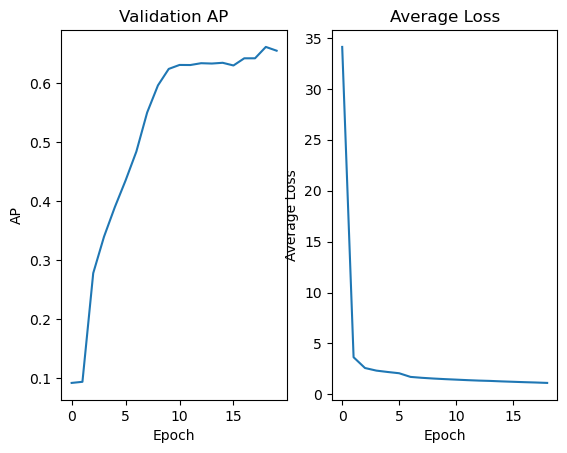

val_aps: [0.09148198731458045, 0.09337387991422964, 0.27758136772235775, 0.3393860481511856, 0.3893526636561362, 0.43476595464340595, 0.4837514457364632, 0.5499395155837328, 0.5958601807996852, 0.6238129080021864, 0.6305338609293255, 0.6303884316631798, 0.6334854307133747, 0.6329178700569839, 0.6341905814762782, 0.6296431444656923, 0.6417892541218211, 0.641802519421862, 0.6610896002867114, 0.6546829871616197]
avg_losses: [34.11619685677921, 3.64339542388916, 2.5864315453697655, 2.3302343873416675, 2.1946191156611725, 2.072211735388812, 1.7122826926848467, 1.6232267968794878, 1.552896499633789, 1.4947354793548584, 1.4444179955650778, 1.3933015150182388, 1.3496578090331133, 1.318446678273818, 1.2719364236382877, 1.2336951213724472, 1.1948956671883078, 1.1621709220549639, 1.121274166247424]


In [8]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(val_aps)
plt.title("Validation AP")
plt.xlabel("Epoch")
plt.ylabel("AP")

plt.subplot(1, 2, 2)
plt.plot(avg_losses)
plt.title("Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

print(f"val_aps: {val_aps}")
print(f"avg_losses: {avg_losses}")

In [9]:
torch.save(net.state_dict(), "runs/voc_person_only_new.pt")